In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Wczytanie danych
adult = pd.read_csv("adultData.csv")

# Ujednolicenie nazw kolumn
adult.columns = adult.columns.str.strip()

# kolumna finalweight nie jest potrzebna
adult = adult.drop(columns=["fnlwgt"], errors="ignore")
print(adult.columns)

# Zmiana znaków '?' na NaN w całym DataFrame. Plik był w formacie ".data" więc trzeba było najpierw zamienić " ?" na NaN
adult.replace([" ?", "?"], np.nan, inplace=True)

# Podsumowanie braków
null_counts = adult.isna().sum()
print("Braki wg kolumn:\n", null_counts)

adult.head(5)

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'income'],
      dtype='object')
Braki wg kolumn:
 age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [38]:
import numpy as np
import pandas as pd

# --- 1) Opis zbioru danych (tekst + podstawowe liczby) ---

def opis_zbioru(df: pd.DataFrame, nazwa: str = "adult") -> None:
    n_rows, n_cols = df.shape
    total_missing = int(df.isna().sum().sum())
    missing_pct = (total_missing / (n_rows * n_cols) * 100) if (n_rows * n_cols) else 0.0

    print(f"Opis zbioru danych: {nazwa}")
    print(f"- Liczba obserwacji (wierszy): {n_rows}")
    print(f"- Liczba zmiennych (kolumn): {n_cols}")
    print(f"- Łączna liczba braków danych: {total_missing} ({missing_pct:.2f}% wszystkich pól)")
    print("- Typy danych (Pandas):")
    print(df.dtypes.value_counts())

opis_zbioru(adult, nazwa="adultData.csv (Adult)")


# --- 2) Skale pomiarowe (heurystyki + możliwość ręcznego nadpisania) ---

# Kolumny zwykle porządkowe w zbiorze Adult (jeśli występują w Twoich danych)
ORDINAL_CANDIDATES = {
    "education": "porządkowa",
    "education-num": "ilorazowa",  # liczba lat edukacji/poziom jako liczba: traktowane ilościowo
}

# Kolumny zwykle ilościowe (ilorazowe)
RATIO_CANDIDATES = {
    "age": "ilorazowa",
    "capital-gain": "ilorazowa",
    "capital-loss": "ilorazowa",
    "hours-per-week": "ilorazowa",
}

# Kolumny zwykle nominalne (kategorie bez porządku)
NOMINAL_CANDIDATES = {
    "workclass": "nominalna",
    "occupation": "nominalna",
    "native-country": "nominalna",
    "marital-status": "nominalna",
    "relationship": "nominalna",
    "race": "nominalna",
    "sex": "nominalna",
    "income": "nominalna",
    "salary": "nominalna",
    "class": "nominalna",
    "education-num": "ilorazowa",
}

def typ_analityczny(series: pd.Series) -> str:
    if pd.api.types.is_numeric_dtype(series):
        return "numeryczna"
    return "kategoryczna"

def skala_pomiarowa(df: pd.DataFrame, col: str) -> str:
    # 1) ręczne mapowania (najpewniejsze)
    if col in ORDINAL_CANDIDATES:
        return ORDINAL_CANDIDATES[col]
    if col in RATIO_CANDIDATES:
        return RATIO_CANDIDATES[col]
    if col in NOMINAL_CANDIDATES:
        return NOMINAL_CANDIDATES[col]

    # 2) heurystyka: liczby -> ilorazowa, reszta -> nominalna
    if pd.api.types.is_numeric_dtype(df[col]):
        return "ilorazowa"
    return "nominalna"


# --- 3) Tabela charakterystyki zmiennych (typy + skale + braki + unikatowość) ---

def charakterystyka_zmiennych(df: pd.DataFrame, sample_n: int = 5) -> pd.DataFrame:
    rows = []
    n = len(df)

    for col in df.columns:
        s = df[col]
        pandas_dtype = str(s.dtype)
        analityczny = typ_analityczny(s)
        skala = skala_pomiarowa(df, col)

        missing = int(s.isna().sum())
        missing_pct = (missing / n * 100) if n else 0.0

        nunique = int(s.nunique(dropna=True))
        nunique_incl_nan = int(s.nunique(dropna=False))

        # przykładowe wartości (bez NaN)
        examples = s.dropna().astype(str).unique()[:sample_n].tolist()

        rows.append({
            "zmienna": col,
            "typ_pandas": pandas_dtype,
            "typ_analityczny": analityczny,
            "skala_pomiarowa": skala,
            "unikaty_bez_NaN": nunique,
            "unikaty_z_NaN": nunique_incl_nan,
            "braki_NaN": missing,
            "braki_%": round(missing_pct, 2),
            "przykładowe_wartości": ", ".join(examples),
        })

    meta = pd.DataFrame(rows).sort_values(["typ_analityczny", "zmienna"]).reset_index(drop=True)
    return meta

meta = charakterystyka_zmiennych(adult, sample_n=6)
display(meta)


# --- 4) Krótki opis „raportowy” do wklejenia do sprawozdania (automatycznie) ---

def opis_raportowy(df: pd.DataFrame, meta: pd.DataFrame, nazwa: str = "Adult") -> None:
    n_rows, n_cols = df.shape
    num_n = int((meta["typ_analityczny"] == "numeryczna").sum())
    cat_n = int((meta["typ_analityczny"] == "kategoryczna").sum())

    print(f"Zbiór danych {nazwa} zawiera {n_rows} obserwacji oraz {n_cols} zmiennych.")
    print(f"Wyróżniono {num_n} zmiennych numerycznych oraz {cat_n} zmiennych kategorycznych.")
    print("Skale pomiarowe przyjęto następująco:")
    print("- nominalna: kategorie bez naturalnego porządku (np. workclass, occupation, native-country)")
    print("- porządkowa: kategorie z porządkiem (np. education, jeśli występuje jako etykiety poziomów)")
    print("- ilorazowa: zmienne ilościowe z zerem absolutnym (np. age, hours-per-week, capital-gain, capital-loss)")
    print("\nPodsumowanie braków (TOP 10):")
    top_missing = meta.sort_values("braki_NaN", ascending=False).head(10)[["zmienna", "braki_NaN", "braki_%"]]
    display(top_missing)

opis_raportowy(adult, meta, nazwa="Adult (adultData.csv)")


Opis zbioru danych: adultData.csv (Adult)
- Liczba obserwacji (wierszy): 32561
- Liczba zmiennych (kolumn): 14
- Łączna liczba braków danych: 4262 (0.93% wszystkich pól)
- Typy danych (Pandas):
object    9
int64     5
Name: count, dtype: int64


,zmienna,typ_pandas,typ_analityczny,skala_pomiarowa,unikaty_bez_NaN,unikaty_z_NaN,braki_NaN,braki_%,przykładowe_wartości
0,education,object,kategoryczna,porządkowa,16,16,0,0.00,"Bachelors, HS-grad, 11th, Masters, 9th, ..."
1,income,object,kategoryczna,nominalna,2,2,0,0.00,"<=50K, >50K"
2,marital-status,object,kategoryczna,nominalna,7,7,0,0.00,"Never-married, Married-civ-spouse, Divorced..."
3,native-country,object,kategoryczna,nominalna,41,42,583,1.79,"United-States, Cuba, Jamaica, India, Mexi..."
4,occupation,object,kategoryczna,nominalna,14,15,1843,5.66,"Adm-clerical, Exec-managerial, Handlers-cle..."
5,race,object,kategoryczna,nominalna,5,5,0,0.00,"White, Black, Asian-Pac-Islander, Amer-Ind..."
6,relationship,object,kategoryczna,nominalna,6,6,0,0.00,"Not-in-family, Husband, Wife, Own-child, ..."
7,sex,object,kategoryczna,nominalna,2,2,0,0.00,"Male, Female"
8,workclass,object,kategoryczna,nominalna,8,9,1836,5.64,"State-gov, Self-emp-not-inc, Private, Fede..."
9,age,int64,numeryczna,ilorazowa,73,73,0,0.00,"39, 50, 38, 53, 28, 37"


Zbiór danych Adult (adultData.csv) zawiera 32561 obserwacji oraz 14 zmiennych.
Wyróżniono 5 zmiennych numerycznych oraz 9 zmiennych kategorycznych.
Skale pomiarowe przyjęto następująco:
- nominalna: kategorie bez naturalnego porządku (np. workclass, occupation, native-country)
- porządkowa: kategorie z porządkiem (np. education, jeśli występuje jako etykiety poziomów)
- ilorazowa: zmienne ilościowe z zerem absolutnym (np. age, hours-per-week, capital-gain, capital-loss)

Podsumowanie braków (TOP 10):


,zmienna,braki_NaN,braki_%
4,occupation,1843,5.66
8,workclass,1836,5.64
3,native-country,583,1.79
1,income,0,0.00
2,marital-status,0,0.00
0,education,0,0.00
5,race,0,0.00
6,relationship,0,0.00
7,sex,0,0.00
9,age,0,0.00


Kolumny numeryczne: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Kolumny kategoryczne: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']


,Liczność,Udział w zbiorze [%],Udział bez NaN [%]
workclass,,,
Private,22696,69.70,73.87
Self-emp-not-inc,2541,7.80,8.27
Local-gov,2093,6.43,6.81
State-gov,1298,3.99,4.22
Self-emp-inc,1116,3.43,3.63
Federal-gov,960,2.95,3.12
Without-pay,14,0.04,0.05
Never-worked,7,0.02,0.02
(braki danych: NaN),1836,5.64,NaN


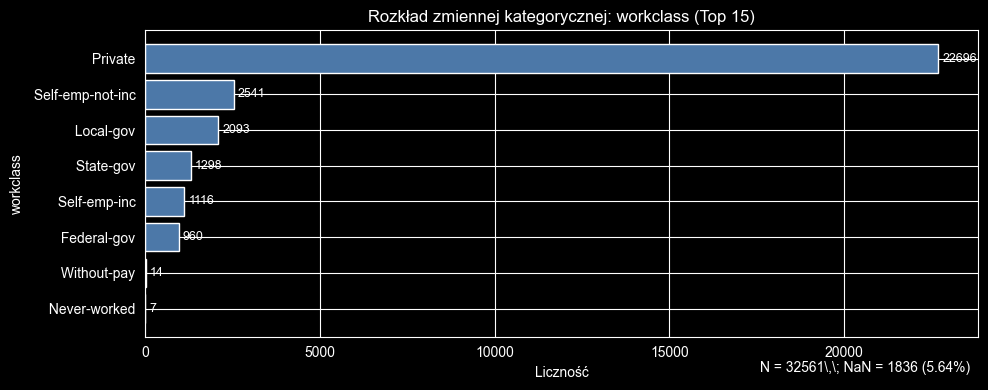

,Liczność,Udział w zbiorze [%],Udział bez NaN [%]
education,,,
HS-grad,10501,32.25,32.25
Some-college,7291,22.39,22.39
Bachelors,5355,16.45,16.45
Masters,1723,5.29,5.29
Assoc-voc,1382,4.24,4.24
11th,1175,3.61,3.61
Assoc-acdm,1067,3.28,3.28
10th,933,2.87,2.87
7th-8th,646,1.98,1.98


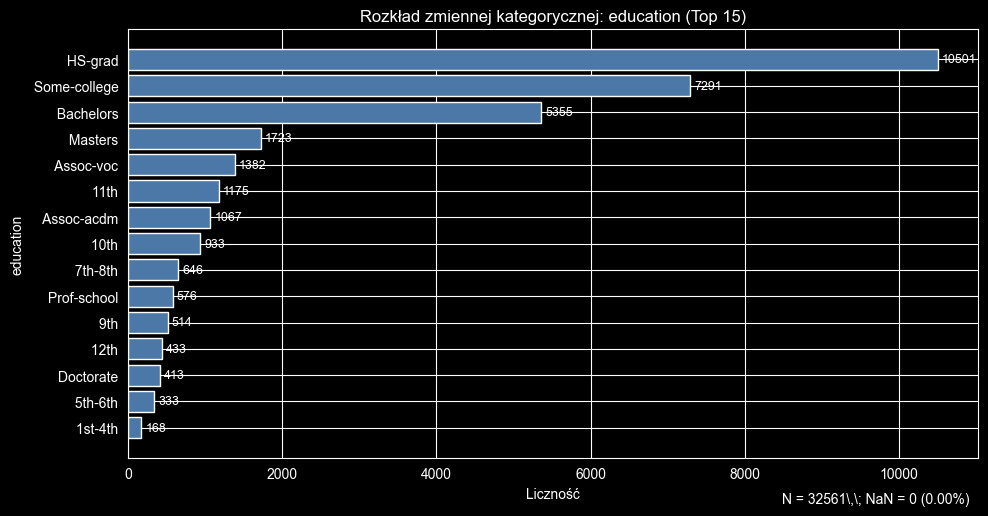

,Liczność,Udział w zbiorze [%],Udział bez NaN [%]
marital-status,,,
Married-civ-spouse,14976,45.99,45.99
Never-married,10683,32.81,32.81
Divorced,4443,13.65,13.65
Separated,1025,3.15,3.15
Widowed,993,3.05,3.05
Married-spouse-absent,418,1.28,1.28
Married-AF-spouse,23,0.07,0.07
(braki danych: NaN),0,0.00,NaN


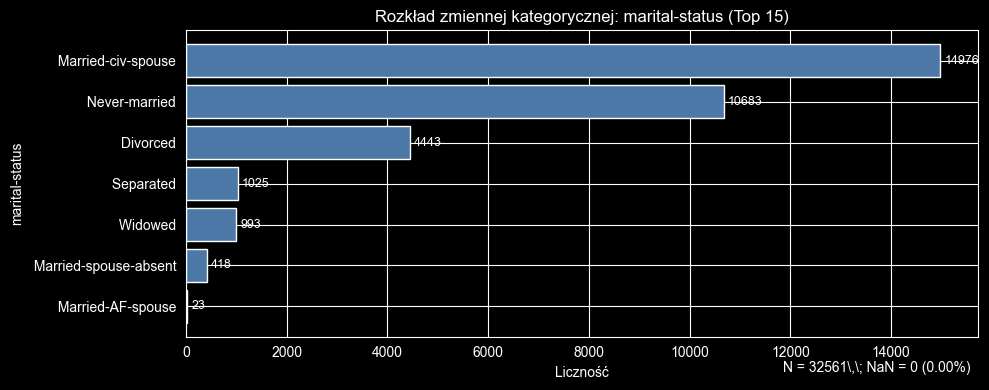

,Liczność,Udział w zbiorze [%],Udział bez NaN [%]
occupation,,,
Prof-specialty,4140,12.71,13.48
Craft-repair,4099,12.59,13.34
Exec-managerial,4066,12.49,13.24
Adm-clerical,3770,11.58,12.27
Sales,3650,11.21,11.88
Other-service,3295,10.12,10.73
Machine-op-inspct,2002,6.15,6.52
Transport-moving,1597,4.90,5.20
Handlers-cleaners,1370,4.21,4.46


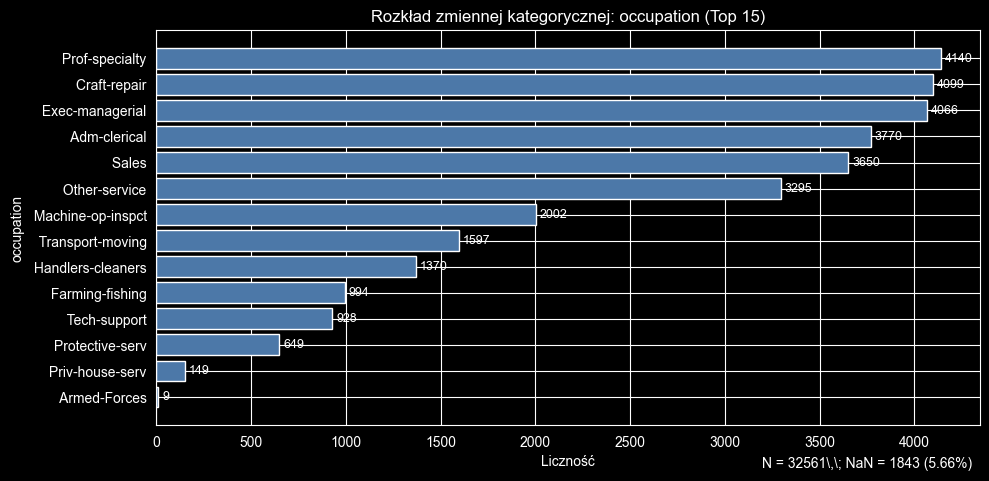

,Liczność,Udział w zbiorze [%],Udział bez NaN [%]
relationship,,,
Husband,13193,40.52,40.52
Not-in-family,8305,25.51,25.51
Own-child,5068,15.56,15.56
Unmarried,3446,10.58,10.58
Wife,1568,4.82,4.82
Other-relative,981,3.01,3.01
(braki danych: NaN),0,0.00,NaN


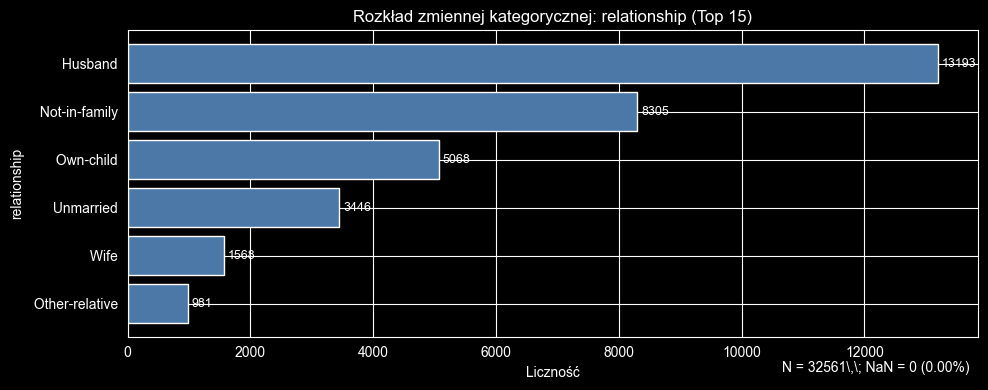

,Liczność,Udział w zbiorze [%],Udział bez NaN [%]
race,,,
White,27816,85.43,85.43
Black,3124,9.59,9.59
Asian-Pac-Islander,1039,3.19,3.19
Amer-Indian-Eskimo,311,0.96,0.96
Other,271,0.83,0.83
(braki danych: NaN),0,0.00,NaN


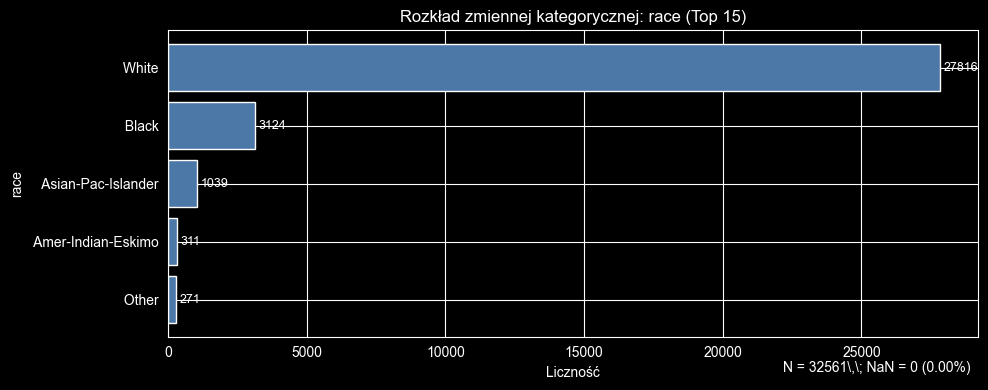

,Liczność,Udział w zbiorze [%],Udział bez NaN [%]
sex,,,
Male,21790,66.92,66.92
Female,10771,33.08,33.08
(braki danych: NaN),0,0.00,NaN


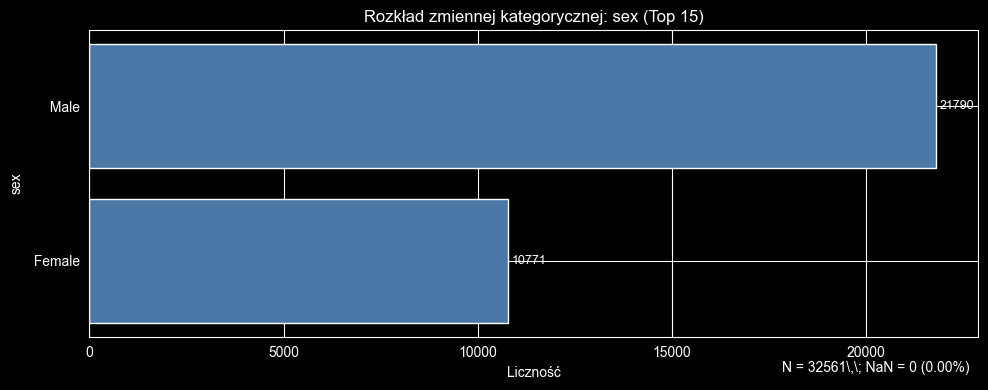

,Liczność,Udział w zbiorze [%],Udział bez NaN [%]
native-country,,,
United-States,29170,89.59,91.22
Mexico,643,1.97,2.01
Philippines,198,0.61,0.62
Germany,137,0.42,0.43
Canada,121,0.37,0.38
Puerto-Rico,114,0.35,0.36
El-Salvador,106,0.33,0.33
India,100,0.31,0.31
Cuba,95,0.29,0.30


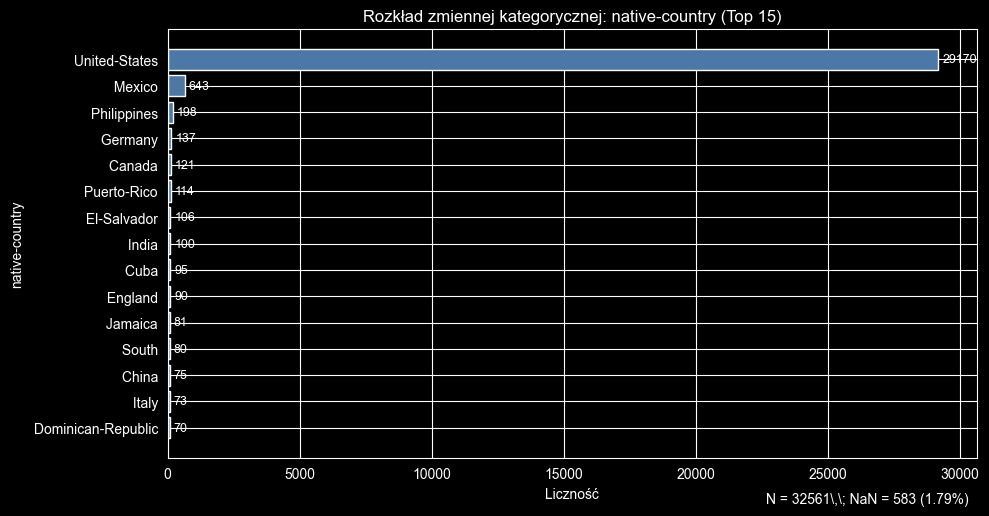

,Liczność,Udział w zbiorze [%],Udział bez NaN [%]
income,,,
<=50K,24720,75.92,75.92
>50K,7841,24.08,24.08
(braki danych: NaN),0,0.00,NaN


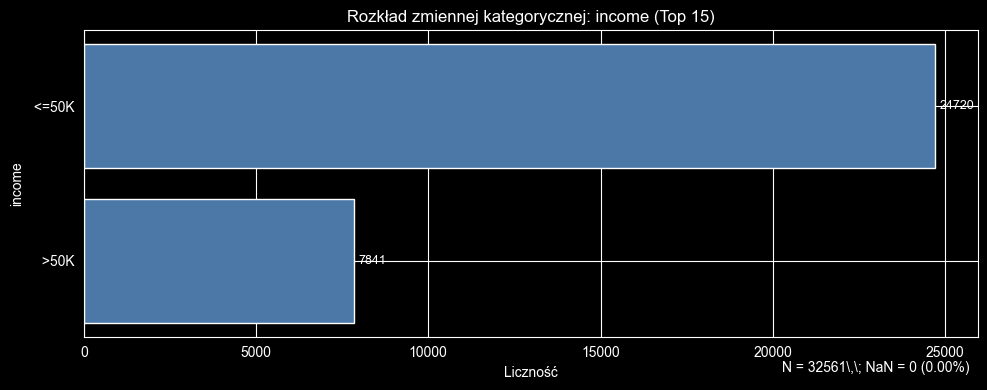

,age
count,32561.000000
mean,38.581647
std,13.640433
min,17.000000
5%,19.000000
25%,28.000000
50%,37.000000
75%,48.000000
95%,63.000000
max,90.000000


C:\Users\zoroa\AppData\Local\Temp\ipykernel_24632\856822864.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


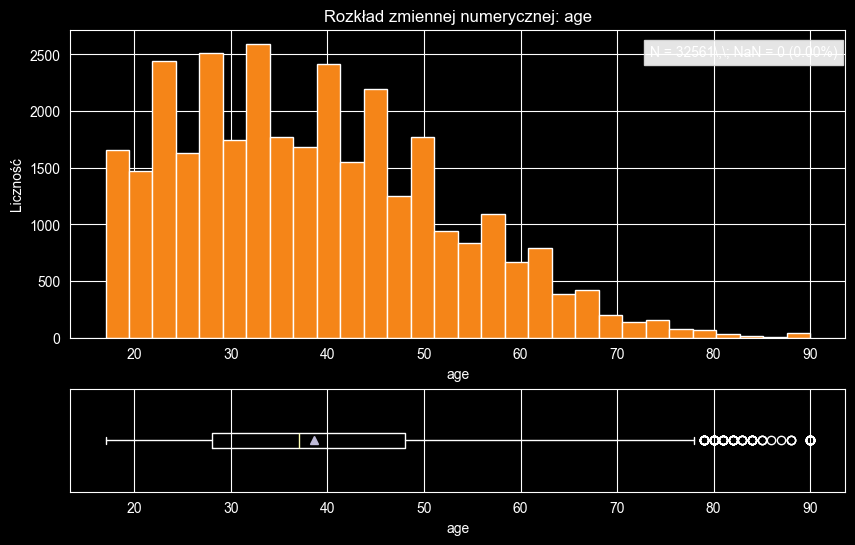

,education-num
count,32561.000000
mean,10.080679
std,2.572720
min,1.000000
5%,5.000000
25%,9.000000
50%,10.000000
75%,12.000000
95%,14.000000
max,16.000000


C:\Users\zoroa\AppData\Local\Temp\ipykernel_24632\856822864.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


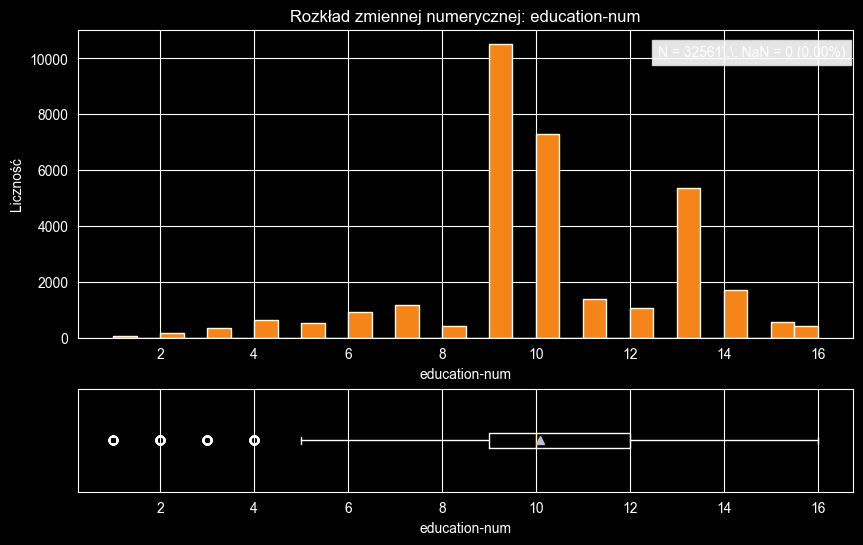

,capital-gain
count,32561.000000
mean,1077.648844
std,7385.292085
min,0.000000
5%,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
95%,5013.000000
max,99999.000000


C:\Users\zoroa\AppData\Local\Temp\ipykernel_24632\856822864.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


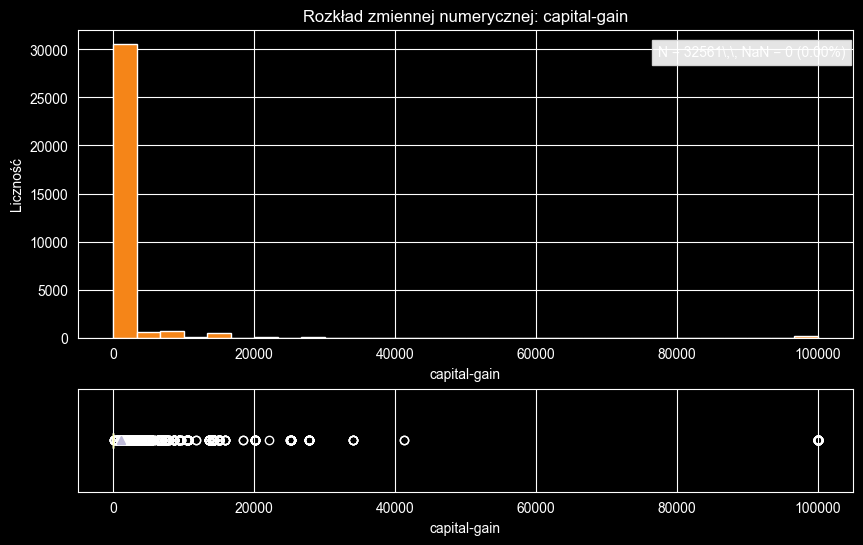

,capital-loss
count,32561.000000
mean,87.303830
std,402.960219
min,0.000000
5%,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
95%,0.000000
max,4356.000000


C:\Users\zoroa\AppData\Local\Temp\ipykernel_24632\856822864.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


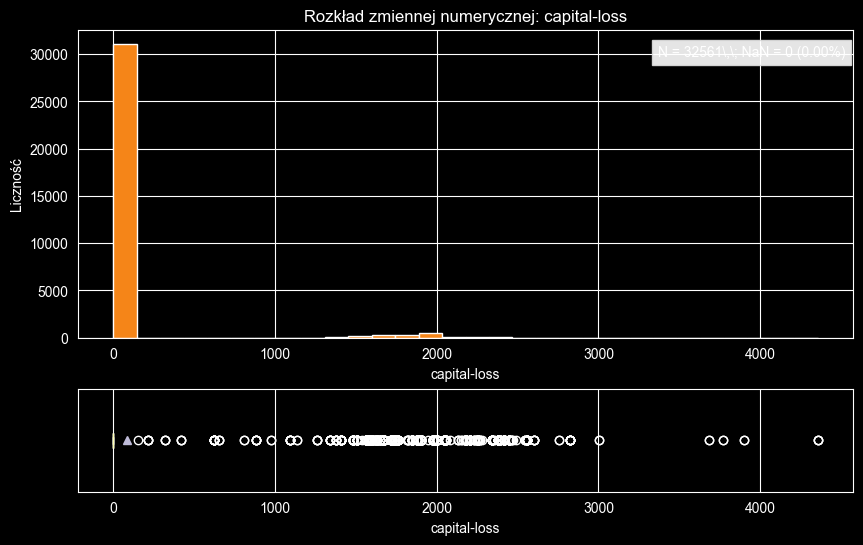

,hours-per-week
count,32561.000000
mean,40.437456
std,12.347429
min,1.000000
5%,18.000000
25%,40.000000
50%,40.000000
75%,45.000000
95%,60.000000
max,99.000000


C:\Users\zoroa\AppData\Local\Temp\ipykernel_24632\856822864.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


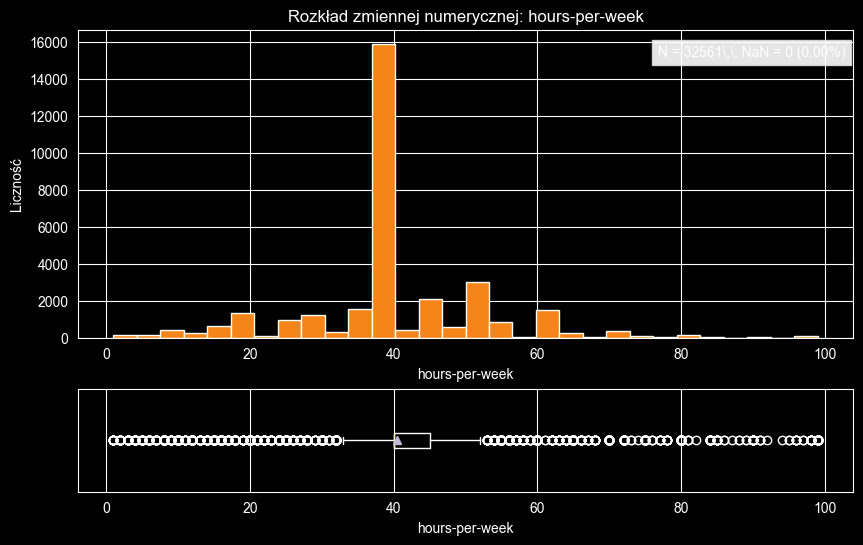

In [39]:
def tabela_kategorie(df: pd.DataFrame, col: str, top_n: int = 15) -> pd.DataFrame:
    """Tabela: liczność, procent, procent bez NaN dla zmiennej kategorycznej."""
    s = df[col]
    n_total = len(s)
    n_missing = int(s.isna().sum())
    n_nonmissing = n_total - n_missing

    vc = s.value_counts(dropna=True)
    out = pd.DataFrame({
        "Liczność": vc,
        "Udział w zbiorze [%]": np.round(vc / n_total * 100, 2),
        "Udział bez NaN [%]": np.round(vc / max(n_nonmissing, 1) * 100, 2),
    })
    out.index.name = col
    out = out.head(top_n)

    info = pd.DataFrame(
        {
            "Liczność": [n_missing],
            "Udział w zbiorze [%]": [round(n_missing / n_total * 100, 2)],
            "Udział bez NaN [%]": [np.nan],
        },
        index=pd.Index(["(braki danych: NaN)"], name=col),
    )
    return pd.concat([out, info], axis=0)

def wykres_kategorie(df: pd.DataFrame, col: str, top_n: int = 15) -> None:
    """Wykres słupkowy (Top-N kategorii) + opis liczby braków."""
    s = df[col]
    vc = s.value_counts(dropna=True).head(top_n)
    n_total = len(s)
    n_missing = int(s.isna().sum())

    fig, ax = plt.subplots(figsize=(10, max(4, 0.35 * len(vc))))
    bars = ax.barh(vc.index.astype(str), vc.values, color="#4C78A8")
    ax.invert_yaxis()
    ax.set_xlabel("Liczność")
    ax.set_ylabel(col)
    ax.set_title(f"Rozkład zmiennej kategorycznej: {col} (Top {top_n})")

    # etykiety na słupkach
    ax.bar_label(bars, padding=3, fontsize=9)

    # podpis o brakach
    ax.text(
        0.99, -0.08,
        f"N = {n_total}\\,\\; NaN = {n_missing} ({(n_missing / n_total * 100):.2f}%)",
        transform=ax.transAxes, ha="right", va="top"
    )

    plt.tight_layout()
    plt.show()

def tabela_numeryczna(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """Opis statystyczny dla zmiennej numerycznej."""
    s = pd.to_numeric(df[col], errors="coerce")
    desc = s.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).to_frame(name=col)
    desc.loc["missing"] = int(s.isna().sum())
    return desc

def wykres_numeryczny(df: pd.DataFrame, col: str, bins: int = 30) -> None:
    """Histogram + boxplot z opisem."""
    s = pd.to_numeric(df[col], errors="coerce")
    n_total = len(s)
    n_missing = int(s.isna().sum())
    s2 = s.dropna()

    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.25)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])

    ax1.hist(s2, bins=bins, color="#F58518", edgecolor="white")
    ax1.set_title(f"Rozkład zmiennej numerycznej: {col}")
    ax1.set_xlabel(col)
    ax1.set_ylabel("Liczność")

    ax2.boxplot(s2, vert=False, showmeans=True)
    ax2.set_xlabel(col)
    ax2.set_yticks([])

    ax1.text(
        0.99, 0.95,
        f"N = {n_total}\\,\\; NaN = {n_missing} ({(n_missing / n_total * 100):.2f}%)",
        transform=ax1.transAxes, ha="right", va="top",
        bbox=dict(facecolor="white", edgecolor="#DDDDDD", alpha=0.9)
    )

    plt.tight_layout()
    plt.show()

# --- Wybór kolumn i generowanie tabel/wykresów ---

# Podział na typy (auto) + proste zabezpieczenie: obiektowe traktujemy jako kategoryczne
num_cols = adult.select_dtypes(include=["number"]).columns.tolist()
cat_cols = adult.select_dtypes(exclude=["number"]).columns.tolist()

print("Kolumny numeryczne:", num_cols)
print("Kolumny kategoryczne:", cat_cols)

# 1) Tabele i wykresy dla zmiennych kategorycznych (Top 15)
for col in cat_cols:
    display(tabela_kategorie(adult, col, top_n=15))
    wykres_kategorie(adult, col, top_n=15)

# 2) Tabele i wykresy dla zmiennych numerycznych
for col in num_cols:
    display(tabela_numeryczna(adult, col))
    wykres_numeryczny(adult, col, bins=30)

In [41]:
# =========================================================
# 3) Imputacja braków danych (kategoryczne): moda w grupie -> fallback globalny
# =========================================================
# UZASADNIENIE WYBORU METODY:
# - workclass, occupation i native-country są zmiennymi kategorycznymi (nominalnymi), więc nie ma sensu
#   uzupełniać ich średnią/medianą. Najbardziej naturalne jest uzupełnianie najczęściej występującą kategorią (modą).
# - Zastosowano modę WARUNKOWĄ (w grupach), bo rozkłady z wcześniejszych tabel/wykresów zwykle pokazują, że
#   np. occupation zależy od workclass i education. Imputacja globalną modą mogłaby nadmiernie zwiększać
#   jedną dominującą kategorię i zniekształcić zależności.
# - Fallback do globalnej mody zabezpiecza sytuacje, gdy w danej grupie brakuje obserwacji niepustych.

def fill_with_group_mode(
    df: pd.DataFrame,
    target: str,
    by: list[str],
    fallback_mode: str | None = None
) -> pd.DataFrame:
    """
    Uzupełnia NaN w `target` modą w grupach `by`.
    Jeśli w grupie nie da się wyznaczyć mody, używa `fallback_mode` (domyślnie globalna moda).
    Dodaje flagę: f"{target}__imputed".
    """
    out = df.copy()
    miss = out[target].isna()

    if fallback_mode is None:
        non_na = out[target].dropna()
        fallback_mode = non_na.mode().iloc[0] if len(non_na) else np.nan

    def _mode_or_nan(x: pd.Series):
        x = x.dropna()
        if len(x) == 0:
            return np.nan
        m = x.mode()
        return m.iloc[0] if len(m) else np.nan

    group_mode = out.groupby(by, dropna=False)[target].transform(_mode_or_nan)

    out.loc[miss, target] = group_mode[miss]
    out[target] = out[target].fillna(fallback_mode)
    out[f"{target}__imputed"] = miss
    return out

adult_imputed = adult.copy()

adult_imputed = fill_with_group_mode(
    adult_imputed,
    target="workclass",
    by=["education", "marital-status"]
)

adult_imputed = fill_with_group_mode(
    adult_imputed,
    target="occupation",
    by=["workclass", "education"]
)

adult_imputed = fill_with_group_mode(
    adult_imputed,
    target="native-country",
    by=["race"]  # lekko warunkowo; można też dać [] dla czysto globalnej mody
)

print("Braki po imputacji:\n", adult_imputed[["workclass", "occupation", "native-country"]].isna().sum())
print("Liczba imputacji:\n", adult_imputed[["workclass__imputed", "occupation__imputed", "native-country__imputed"]].sum())



Braki po imputacji:
 workclass         0
occupation        0
native-country    0
dtype: int64
Liczba imputacji:
 workclass__imputed         1836
occupation__imputed        1843
native-country__imputed     583
dtype: int64


In [42]:
# =========================================================
# 4) Analiza obserwacji nietypowych (numeryczne): IQR + Z-score
# =========================================================
# UZASADNIENIE WYBORU METOD:
# Wybrano dwie komplementarne metody identyfikacji wartości odstających dla zmiennych numerycznych:
# 1) IQR (Tukey, k=1.5):
#    - nie zakłada normalności rozkładu; dobrze działa przy skośnych rozkładach (co często widać na histogramach),
#    - odporny na ekstremalne wartości, bo opiera się o kwartyle.
# 2) Z-score (|z|>3):
#    - metoda klasyczna, łatwa do interpretacji (odległość od średniej w odchyleniach standardowych),
#    - przydatna zwłaszcza wtedy, gdy rozkład jest zbliżony do normalnego lub po transformacji.
# Uwaga: to jest analiza/flagowanie obserwacji nietypowych (diagnostyka). Nie usuwamy ich automatycznie,
# bo w danych społeczno-ekonomicznych outliery mogą być wartościami poprawnymi (np. bardzo wysokie dochody).

num_cols = adult_imputed.select_dtypes(include=["number"]).columns.tolist()

def outliers_iqr(df: pd.DataFrame, col: str, k: float = 1.5) -> pd.Series:
    s = pd.to_numeric(df[col], errors="coerce")
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lo = q1 - k * iqr
    hi = q3 + k * iqr
    return (s < lo) | (s > hi)

def outliers_zscore(df: pd.DataFrame, col: str, thr: float = 3.0) -> pd.Series:
    s = pd.to_numeric(df[col], errors="coerce")
    mu = s.mean()
    sigma = s.std(ddof=0)
    if pd.isna(sigma) or sigma == 0:
        return pd.Series(False, index=df.index)
    z = (s - mu) / sigma
    return z.abs() > thr

outlier_summary = []
for c in num_cols:
    iqr_mask = outliers_iqr(adult_imputed, c)
    z_mask = outliers_zscore(adult_imputed, c)
    outlier_summary.append({
        "kolumna": c,
        "IQR_outliers": int(iqr_mask.sum(skipna=True)),
        "IQR_outliers_%": float((iqr_mask.mean(skipna=True) * 100).round(2)),
        "Z_outliers": int(z_mask.sum(skipna=True)),
        "Z_outliers_%": float((z_mask.mean(skipna=True) * 100).round(2)),
    })

outlier_summary_df = pd.DataFrame(outlier_summary).sort_values(by="IQR_outliers", ascending=False)
print("Podsumowanie obserwacji nietypowych:\n", outlier_summary_df)

# (opcjonalnie) prosta wizualizacja dla wybranej kolumny numerycznej
def plot_outliers_box(df: pd.DataFrame, col: str) -> None:
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    plt.figure(figsize=(10, 2.2))
    plt.boxplot(s, vert=False, showmeans=True)
    plt.title(f"Wykres pudełkowy (outliers): {col}")
    plt.xlabel(col)
    plt.yticks([])
    plt.tight_layout()
    plt.show()



Podsumowanie obserwacji nietypowych:
           kolumna  IQR_outliers  IQR_outliers_%  Z_outliers  Z_outliers_%
4  hours-per-week          9008           27.66         440          1.35
2    capital-gain          2712            8.33         215          0.66
3    capital-loss          1519            4.67        1470          4.51
1   education-num          1198            3.68         219          0.67
0             age           143            0.44         121          0.37


Charakterystyki numeryczne:
                   count         mean          std   min    5%   25%   50%  \
age             32561.0    38.581647    13.640433  17.0  19.0  28.0  37.0   
education-num   32561.0    10.080679     2.572720   1.0   5.0   9.0  10.0   
capital-gain    32561.0  1077.648844  7385.292085   0.0   0.0   0.0   0.0   
capital-loss    32561.0    87.303830   402.960219   0.0   0.0   0.0   0.0   
hours-per-week  32561.0    40.437456    12.347429   1.0  18.0  40.0  40.0   

                 75%     95%      max  median  
age             48.0    63.0     90.0    37.0  
education-num   12.0    14.0     16.0    10.0  
capital-gain     0.0  5013.0  99999.0     0.0  
capital-loss     0.0     0.0   4356.0     0.0  
hours-per-week  45.0    60.0     99.0    40.0  
Przykładowe częstości (top 10) dla pierwszej kolumny kategorycznej:

workclass 
                   liczność  procent_%
workclass                            
Private              24529      75.33
Self-emp-not-inc      254

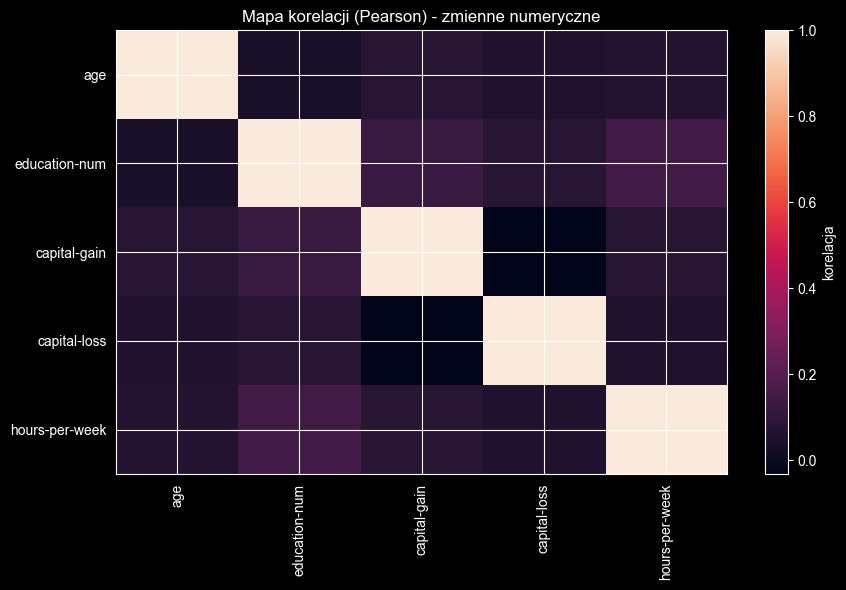

Podgląd po standaryzacji (pierwsze 5 wierszy numerycznych):
         age  education-num  capital-gain  capital-loss  hours-per-week
0  0.030671       1.134739      0.148453      -0.21666       -0.035429
1  0.837109       1.134739     -0.145920      -0.21666       -2.222153
2 -0.042642      -0.420060     -0.145920      -0.21666       -0.035429
3  1.057047      -1.197459     -0.145920      -0.21666       -0.035429
4 -0.775768       1.134739     -0.145920      -0.21666       -0.035429
Wymiary po one-hot: (32561, 112)
Przykładowe kolumny po one-hot:
 ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th']


In [43]:
# =========================================================
# 5) Podstawowe charakterystyki: opis numerycznych, częstości, korelacje
# =========================================================
# UZASADNIENIE (CO I PO CO LICZYMY):
# - średnia, mediana, odchylenie standardowe i percentyle: opisują poziom typowy i zróżnicowanie cech,
#   a mediana/percentyle są odporne na skośność i wartości odstające.
# - częstości dla kategorycznych: pokazują dominujące klasy, nierównowagę kategorii i ułatwiają dobór imputacji.
# - korelacje (Pearson) dla numerycznych: weryfikują zależności liniowe i pomagają wykryć współliniowość.
#   Mapę korelacji dodano dla czytelnej, "wizualnej" oceny relacji między cechami.

# Statystyki opisowe dla numerycznych
desc_num = adult_imputed[num_cols].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T
desc_num["median"] = adult_imputed[num_cols].median(numeric_only=True)
desc_num["std"] = adult_imputed[num_cols].std(numeric_only=True)
print("Charakterystyki numeryczne:\n", desc_num)

# Częstości dla kategorycznych (top 10)
cat_cols = adult_imputed.select_dtypes(exclude=["number"]).columns.tolist()
freq_tables = {}
for c in cat_cols:
    freq_tables[c] = pd.DataFrame({
        "liczność": adult_imputed[c].value_counts(dropna=False).head(10),
        "procent_%": (adult_imputed[c].value_counts(dropna=False, normalize=True).head(10) * 100).round(2),
    })
print("Przykładowe częstości (top 10) dla pierwszej kolumny kategorycznej:\n")
if len(cat_cols) > 0:
    print(cat_cols[0], "\n", freq_tables[cat_cols[0]])

# Korelacje (Pearson) dla numerycznych
corr = adult_imputed[num_cols].corr(numeric_only=True, method="pearson")
print("Macierz korelacji (Pearson):\n", corr)

plt.figure(figsize=(9, 6))
plt.imshow(corr, aspect="auto")
plt.colorbar(label="korelacja")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Mapa korelacji (Pearson) - zmienne numeryczne")
plt.tight_layout()
plt.show()

# =========================================================
# 6) Dwie metody przekształcania zmiennych: standaryzacja + one-hot
# =========================================================
# UZASADNIENIE WYBORU TRANSFORMACJI:
# 6.1 Standaryzacja (z-score) zmiennych numerycznych:
# - sprowadza cechy do porównywalnej skali (średnia 0, odchylenie 1),
# - jest kluczowa dla metod wrażliwych na skalę (np. k-NN, SVM, regresje z regularyzacją, PCA),
# - nie zmienia kształtu rozkładu (tylko skalę/położenie).
# 6.2 Kodowanie one-hot dla zmiennych kategorycznych:
# - zamienia kategorie nominalne na zmienne binarne, co umożliwia użycie większości algorytmów ML,
# - nie narzuca sztucznego porządku kategoriom (w przeciwieństwie do etykietowania liczbami 0/1/2...).

# 6.1 Standaryzacja (z-score) numerycznych
adult_scaled = adult_imputed.copy()
for c in num_cols:
    s = pd.to_numeric(adult_scaled[c], errors="coerce")
    mu = s.mean()
    sigma = s.std(ddof=0)
    if pd.isna(sigma) or sigma == 0:
        adult_scaled[c] = s  # brak sensu skalować
    else:
        adult_scaled[c] = (s - mu) / sigma

print("Podgląd po standaryzacji (pierwsze 5 wierszy numerycznych):\n", adult_scaled[num_cols].head())

# 6.2 Kodowanie one-hot dla kategorycznych
adult_ohe = pd.get_dummies(adult_imputed, columns=cat_cols, dummy_na=False, drop_first=False)
print("Wymiary po one-hot:", adult_ohe.shape)
print("Przykładowe kolumny po one-hot:\n", adult_ohe.columns[:20].tolist())